# Stroke prediction

## Introduction

The goal of this model is to predict if a person is going to suffer a stroke.

Since false negative are more important (false positives can be checked at the hospital), we are going to add more weight on those in the loss function. 

### Background

A stroke occurs when the blood supply to part of your brain is interrupted or reduced, preventing brain tissue from getting oxygen and nutrients. Brain cells begin to die in minutes. A stroke is a medical emergency, and prompt treatment is crucial. Early action can reduce brain damage and other complications. The good news is that many fewer Americans die of stroke now than in the past. Effective treatments can also help prevent disability from stroke.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import sklearn
import imblearn

from bokeh.io import push_notebook, output_notebook, show
from bokeh.palettes import Category20c
from bokeh.plotting import figure
from bokeh.transform import cumsum

In [102]:
output_notebook()

sns.set_style('whitegrid')
cmap = sns.color_palette("Blues", as_cmap=True)

%matplotlib inline

import warnings 
warnings.filterwarnings('ignore')

Loading BokehJS ...

In [3]:
from sklearn.utils import check_random_state
np.random.seed(42)
assert check_random_state is not None, "Set numpy seed for determinism."

In [4]:
df = pd.read_csv('../dataset/stroke.csv').drop(columns=['id'])

In [5]:
df.head()

gender   age  hypertension  heart_disease ever_married      work_type  \
0    Male  67.0             0              1          Yes        Private   
1  Female  61.0             0              0          Yes  Self-employed   
2    Male  80.0             0              1          Yes        Private   
3  Female  49.0             0              0          Yes        Private   
4  Female  79.0             1              0          Yes  Self-employed   

  Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
0          Urban             228.69  36.6  formerly smoked       1  
1          Rural             202.21   NaN     never smoked       1  
2          Rural             105.92  32.5     never smoked       1  
3          Urban             171.23  34.4           smokes       1  
4          Rural             174.12  24.0     never smoked       1

In [6]:
df.shape

(5110, 11)

In [7]:
df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [8]:
categorical_cols = df.select_dtypes(include=object).columns
binary_cols = ['stroke', 'hypertension', 'heart_disease']
numerical_cols = df.select_dtypes(include=np.number).columns.drop(binary_cols)
print(f'Numerical variables: {len(numerical_cols)}')
print(f'Categorical variables: {len(categorical_cols) + len(binary_cols)}')

Numerical variables: 3
Categorical variables: 8


In [9]:
df[categorical_cols].describe()

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

## Visualization

In [10]:
fig1, ax1 = plt.subplots()
ax1.pie(df['stroke'].value_counts(), explode=[0, 0.3], labels=['no stroke', 'stroke'], autopct='%1.1f%%',
        shadow=True, startangle=180)
ax1.set_title('Stroke class proportion', loc='center', y=1.0, fontsize=14, fontweight='bold')
ax1.axis('equal')

plt.show()

The dataset is **imbalanced**. We will take this into account in the next sections by using a resampling method such as SMOTE.

In [11]:
from math import pi

len_data = len(df)
len_m = len(df[df["gender"]=="Male"])
len_w = len_data - len_m

men_stroke = len(df.loc[(df["stroke"]==1)&(df['gender']=="Male")])
men_no_stroke = len_m - men_stroke

women_stroke = len(df.loc[(df["stroke"]==1) & (df['gender']=="Female")])
women_no_stroke = len_w - women_stroke

x = {
    'Men with stroke': men_stroke,
    'Women with stroke': women_stroke,
    'Men healthy': men_no_stroke,
    'Women healthy': women_no_stroke
}
          
data = pd.Series(x).reset_index(name='value').rename(columns={'index':'label'})
data['angle'] = data['value']/data['value'].sum() * 2*pi
data['color'] = Category20c[len(x)]

p = figure(plot_height=350, toolbar_location=None,
           tools="hover", tooltips="@label: @value", x_range=(-0.5, 1.0))
p.title.text = 'Stroke class grouped by gender'
p.title.align = 'center'
p.title.text_color = 'black'
p.wedge(x=0, y=1, radius=0.4,
        start_angle=cumsum('angle', include_zero=True), end_angle=cumsum('angle'),
        line_color="white", fill_color='color', legend_field='label', source=data)

p.axis.axis_label=None
p.axis.visible=False
p.grid.grid_line_color = None

show(p)

The classes representation seems to be proportioned when partition by each numerical variable.

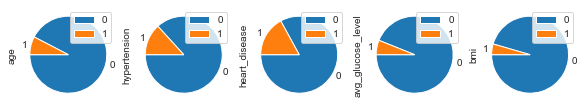

In [12]:
_ = df.groupby(['stroke']).sum().plot(kind='pie', subplots=True, figsize=(10,5), startangle=180)

Next, we are going to have a look at the **categorical variables**.

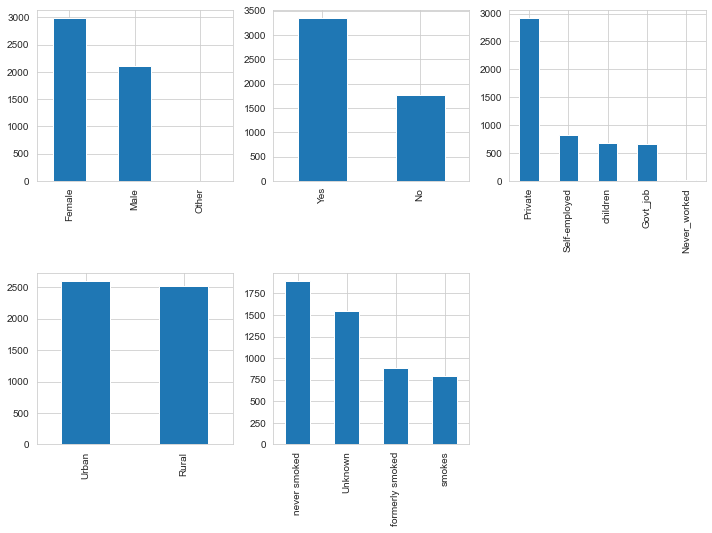

In [13]:
fig, axes = plt.subplots(3,3,figsize=(10,10))

for i, c in enumerate(categorical_cols):
  if c == 'stroke': pass
  ax = axes.reshape(-1)[i]
  df[c].value_counts().plot(kind='bar', ax=ax)

# Do not show empty plots
for ax in axes.reshape(-1)[len(categorical_cols):]:
    ax.set_visible(False)
    
plt.tight_layout()

...and how stroke is distributed among the categorical variables.

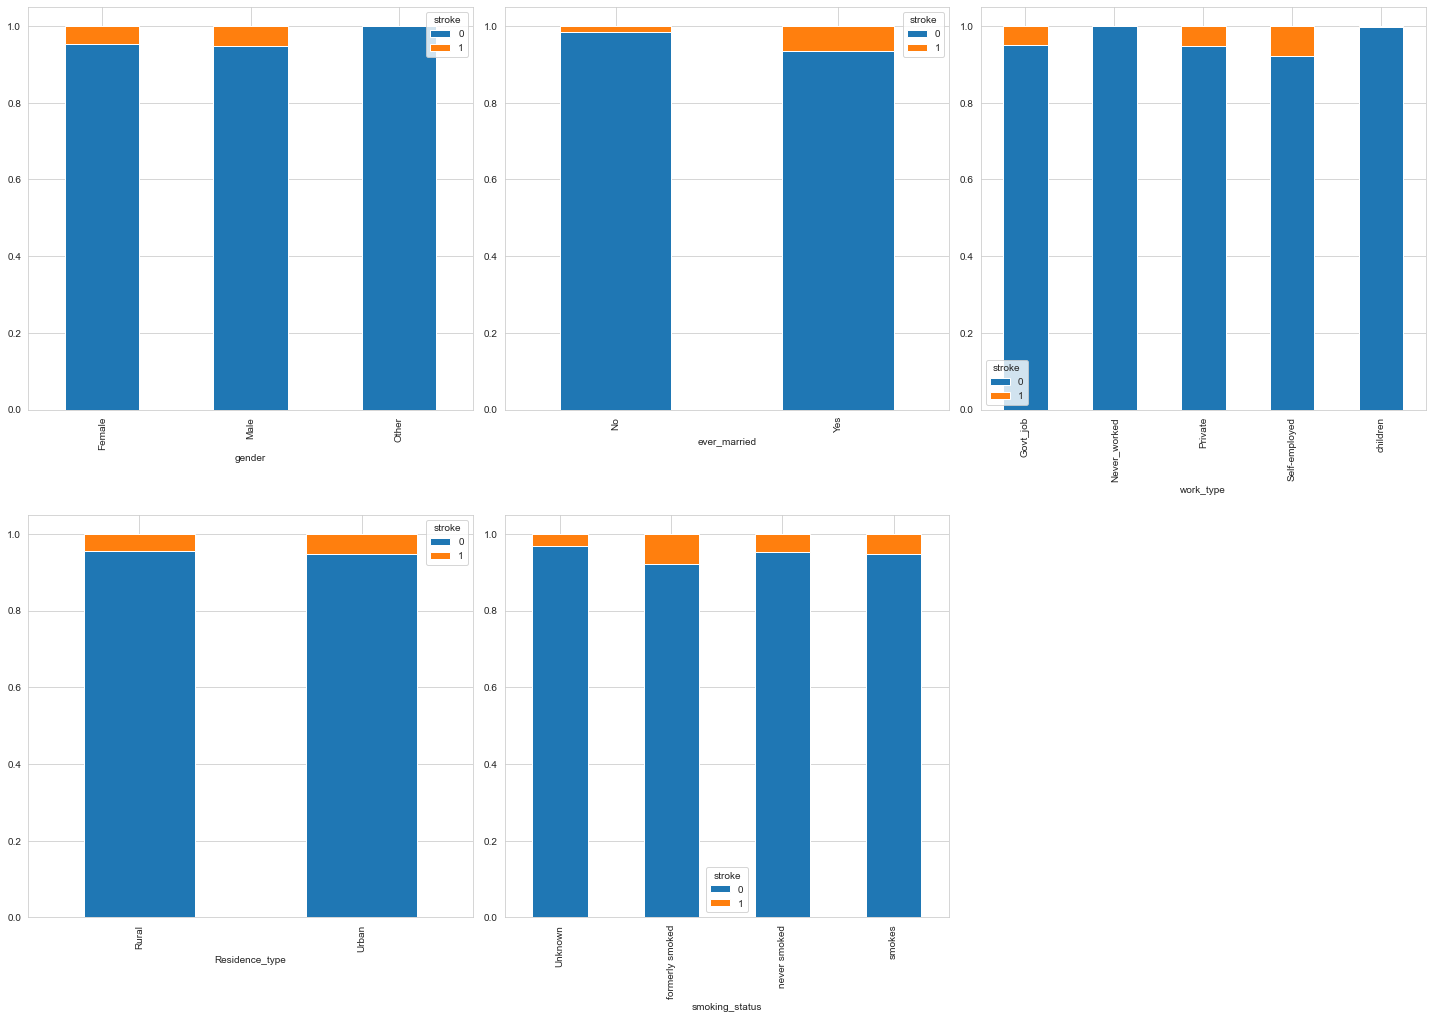

In [14]:
fig, axes = plt.subplots(3,3,figsize=(20,20))

for i, c in enumerate(categorical_cols):
  ax = axes.reshape(-1)[i]
  ct = pd.crosstab(index=df[c], columns=df['stroke'],normalize='index')
  a = ct.plot(kind='bar', stacked=True,ax=ax)

# Do not show empty plots
for ax in axes.reshape(-1)[len(categorical_cols):]:
    ax.set_visible(False)
    
plt.tight_layout()

- Stroke doesn't seem to be highly correlated to smoke since the proportion of person having a strok is farily the same among the different smoking status.
- Men are more prone to stroke than women.
- The gender does not discriminite a person having a stroke or not.
- Hypertension and heart disease does affect a person having a stroke.
- Rural people is less prone to stroke.

Let's have a look at the KDE plots of the **numerical variables** by stroke.

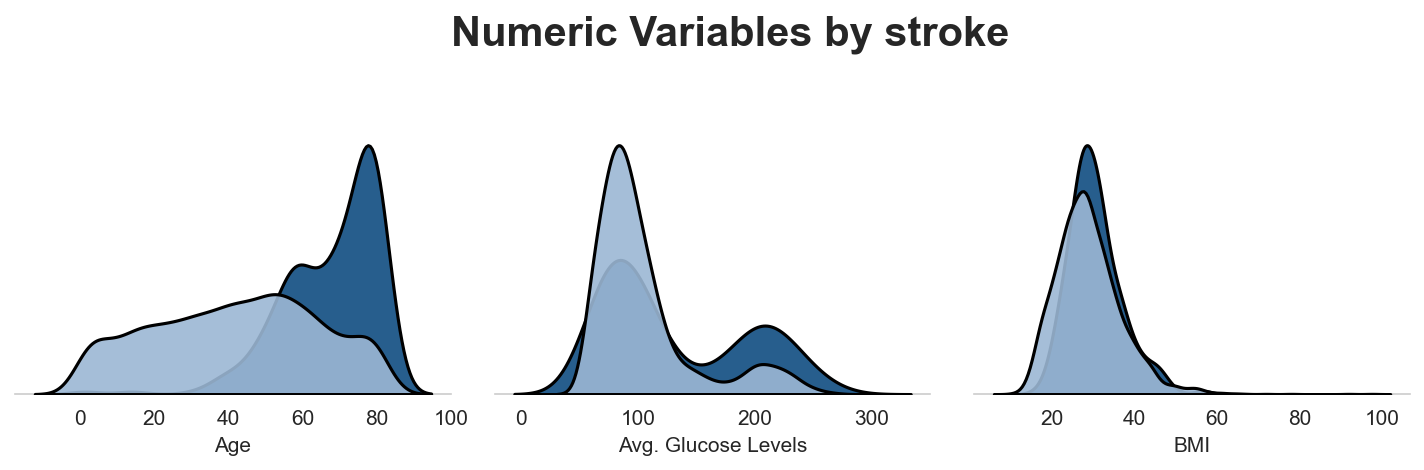

In [15]:
fig = plt.figure(figsize=(12, 12), dpi=150)
gs = fig.add_gridspec(4, 3)
gs.update(wspace=0.1, hspace=0.4)

plot = 0
for row in range(0, 1):
    for col in range(0, 3):
        locals()["ax"+str(plot)] = fig.add_subplot(gs[row, col])
        locals()["ax"+str(plot)].tick_params(axis='y', left=False)
        locals()["ax"+str(plot)].get_yaxis().set_visible(False)
        for s in ["top","right","left"]:
            locals()["ax"+str(plot)].spines[s].set_visible(False)
        plot += 1

plot = 0

s = df[df['stroke'] == 1]
ns = df[df['stroke'] == 0]

for feature in numerical_cols:
        sns.kdeplot(s[feature], ax=locals()["ax"+str(plot)], color='#0f4c81', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        sns.kdeplot(ns[feature],ax=locals()["ax"+str(plot)], color='#9bb7d4', shade=True, linewidth=1.5, ec='black',alpha=0.9, zorder=3, legend=False)
        locals()["ax"+str(plot)].grid(which='major', axis='x', zorder=0, color='gray', linestyle=':', dashes=(1,5))
        plot += 1

ax0.set_xlabel('Age')
ax1.set_xlabel('Avg. Glucose Levels')
ax2.set_xlabel('BMI')
        
ax0.text(100, 0.056, 'Numeric Variables by stroke', fontsize=20, fontweight='bold')

plt.show()

Age looks to be a prominent factor.

## Preprocessing

Age should be rounded to a natural.

In [16]:
df['age'] = df['age'].apply(round)

Binary categorical variables should be modeled properly.

In [17]:
def binary2Categorical(df, cols):
  for c in cols:
    df[c] = pd.cut(df[c], bins=[-0.5,0.5,1.5], labels=['no', 'yes'])

In [18]:
binary_cols = ['hypertension', 'heart_disease']    
binary2Categorical(df, binary_cols)
categorical_cols = df.select_dtypes(include=[object, 'category']).columns

### Dealing with outliers

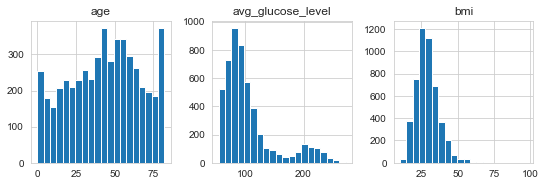

In [19]:
_ = df[numerical_cols].hist(bins=20, layout=(2,3), figsize=(9,6))

We are not applying log scale to _avg_glucose_level_ nor _bmi_ since the skewness is not concerning.

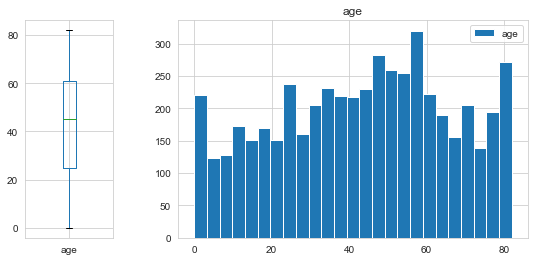

In [20]:
fig, axes= plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 4]}, figsize=(9,4))
df.boxplot(column='age',ax=axes[0])
_ = df.hist(bins=25, column='age', ax=axes[1], legend=True)

Here we could have used IQR filtering but it would have removed the values of the extrem of the interval which is no good.

After some research [Overweight & Obesity](https://www.cdc.gov/obesity/adult/defining.html), we have considered $15 \leq \text{BMI} \leq 60$ an outlier.

In [21]:
df['bmi'] = df['bmi'].apply(lambda bmi_value: bmi_value if 15 < bmi_value < 60 else np.nan)

There is only one person with 'Other' gender so we will consider it an outlier.

In [22]:
df = df[df['gender'] != 'Other']

### Replace Low Frequency Categorical Variables

In [23]:
def replaceLowFreq(df, threshold=0.1, replacement='other'):
    f = lambda x: x.map(x.value_counts(normalize=True)) >= threshold
    r = df[categorical_cols].where(df[categorical_cols].apply(f), replacement)
    df[categorical_cols] = r

#replaceLowFreq(df, threshold=0.1)

We decided **not** to group low frequency categorical variables because each categorical variables has already a small range of possible values.

### Imputation

In [24]:
def displayMissingValues():
    plt.title('Amount Of Missing Values',fontsize=14, y=-0.2)
    ax = sns.heatmap(pd.DataFrame(df.isna().sum()),annot=True, fmt='d', vmin=0, vmax=df.shape[0])
displayMissingValues()

We are going to impute the missing bmi values using a Decision Tree based with variables age and gender since it is clear that there is a correlation between those three variables.

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

imp_dt = DecisionTreeRegressor(random_state=42)

pipe = \
  Pipeline(steps=[('scale',StandardScaler()), 
                  ('imputer', imp_dt)])

X = df[['age','gender','bmi']].copy()
X.gender = X.gender.replace({'Male':0,'Female':1,'Other':-1}).astype(np.uint8)

Missing = X[X.bmi.isna()]
X = X[~X.bmi.isna()]
Y = X.pop('bmi')
pipe.fit(X,Y)
predicted_bmi = pd.Series(pipe.predict(Missing[['age','gender']]), index=Missing.index)
df.loc[Missing.index,'bmi'] = predicted_bmi

In [26]:
displayMissingValues()

### Correlation

In [27]:
fig = px.parallel_categories(df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type',
       'smoking_status', 'stroke']], color='stroke', color_continuous_scale=px.colors.sequential.Inferno)
fig.show()

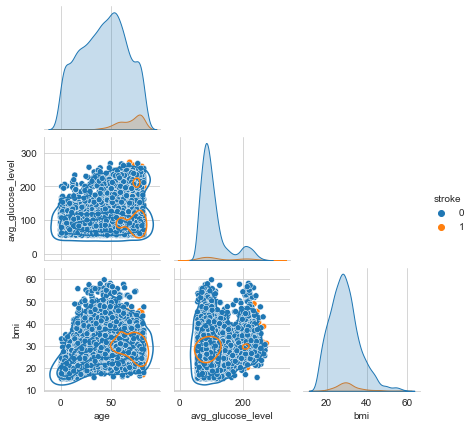

In [28]:
# This is terribly slow...
g = sns.pairplot(df, diag_kind="kde", hue='stroke', corner=True, height=2.0)
g.map_lower(sns.kdeplot, levels=4, color=".2")

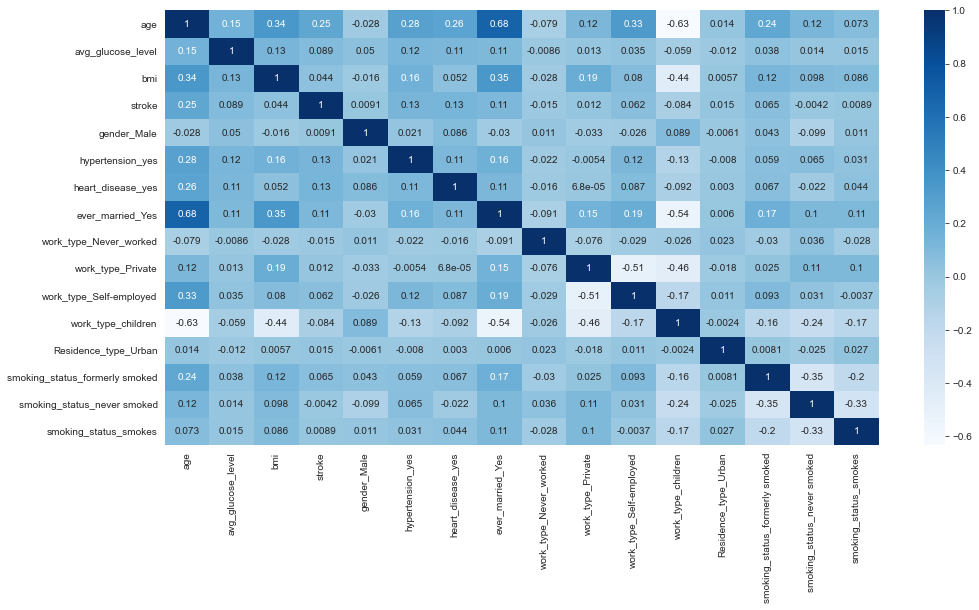

In [103]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df_aux = df.apply(encoder.fit_transform)

plt.figure(figsize=(16,8))
sns.heatmap(df_aux.corr(),cmap=cmap, annot=True);

### Factor Analysis

In [30]:
import prince

def MCA(n_components):
  mca = prince.MCA(
          n_components=n_components,
          n_iter=100,
          copy=True,
          check_input=True,
          engine='auto',
          random_state=42)
  return mca

def printMCA(X, n_components):
  mca = MCA(n_components)
  mca = mca.fit(X)
    
  plt.plot(np.cumsum(mca.explained_inertia_))
  plt.title('Cumulative sum of inertia')
    
  mca.plot_coordinates(
    X=X,
    ax=None,
    figsize=(12, 12),
    show_row_points=True,
    row_points_size=10,
    show_row_labels=False,
    show_column_points=True,
    column_points_size=30,
    show_column_labels=True,
    legend_n_cols=1)

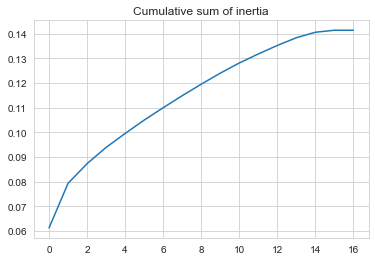

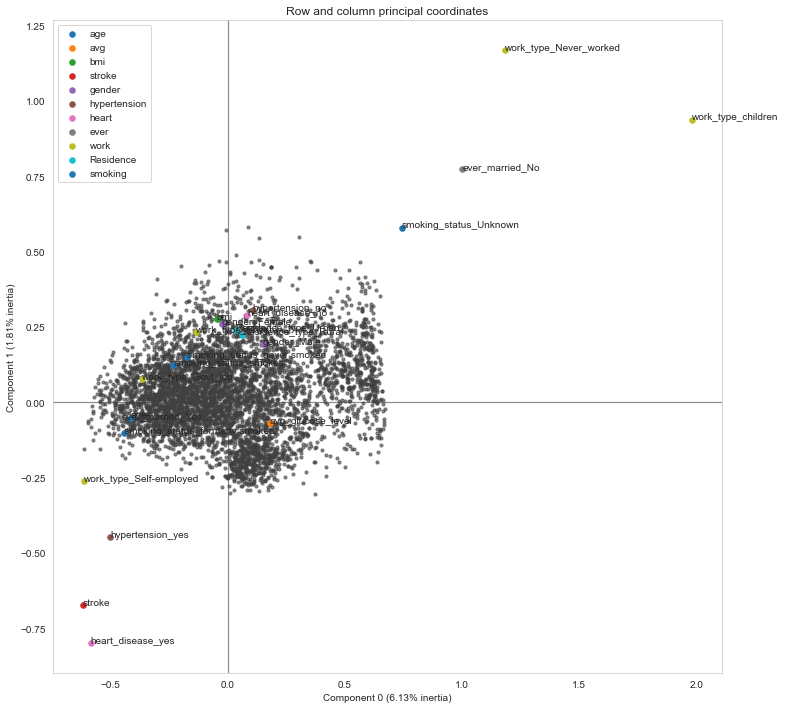

In [31]:
printMCA(df, n_components=17)

The inertia is really low since MCA only uses categorical variables.

Let's try binning the numerical variables into categorical ones in order to use them on the MCA.

In [32]:
def binNumericalVariables(X):
  r = X.copy()
  r.drop(columns=['age', 'bmi', 'avg_glucose_level'])
  r['age'] = pd.cut(X['age'], bins=[0,13,18,45,60,150], labels=['children', 'teens', 'adults', 'seniors', 'elderly'])
  r['bmi'] = pd.cut(X['bmi'], bins=[0,19,25,30,300], labels=['underweight', 'normal', 'overweight', 'obesity'])
  r['avg_glucose_level'] = pd.cut(X['avg_glucose_level'], bins=[0,90,160,230,500], labels=['low','normal','high','very high']) 
  return r

The glucose level binning is extracted from this [blog](https://agamatrix.com/blog/normal-blood-sugar-level-chart/).

In [33]:
df_mca = binNumericalVariables(df)

All variables are now encoded as binary or categorical

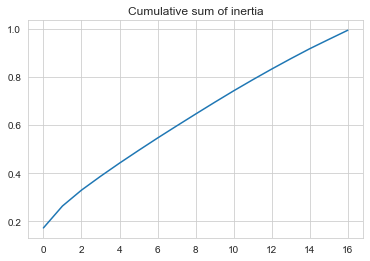

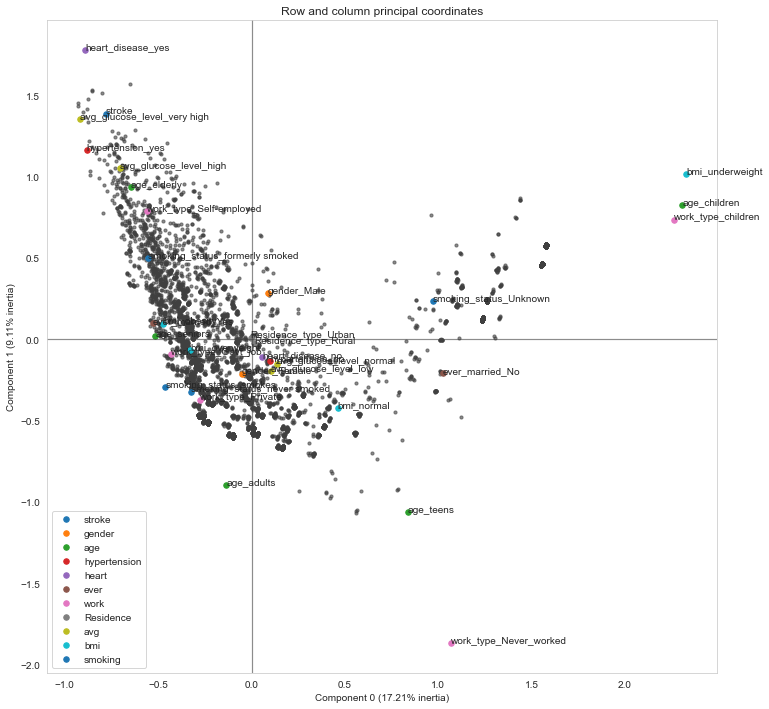

In [34]:
printMCA(df_mca, n_components=17)

We will not explore dimensionality reduction any further since the inertia in the principal axes is really low and you must pick lots of components to not lose information.

### Encoding categorical variables

Most of the classifiers do not work with categorical variables so we need to transform them into numerical ones.

In [35]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [36]:
df.columns.values

array(['age', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Male',
       'hypertension_yes', 'heart_disease_yes', 'ever_married_Yes',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'Residence_type_Urban', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype=object)

## Modeling

Since the dataset is imbalanced, a useful baseline to beat is the _the null accuracy_. We will use the inverse since we are predicting the positive case 'stroke'.  

Our baseline will be $\approx 5\%$ for recall of positive stroke.

### Over-sampling

In order to fix the problem of imbalance, we are going to use SMOTE (Synthetic Minority Over-sampling Technique) which is an over-sampling method based on linear interpolation of the k-Nearest Neighbors.

In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

smote = SMOTE(random_state=42, k_neighbors=5)
scaler = StandardScaler()

# Most of the preprocessing has been done previsouly
def preprocessing(X, y, is_testing):
  if is_testing:
    # Do not resample testing instances
    X_re, y_re = X, y
  else:
    X_re, y_re = smote.fit_resample(X, y)
  # Centering and scaling is important since most of the algorithm
  # e.g. SVM or linear models assume this.
  X_re = scaler.fit_transform(X_re)
  return X_re, y_re

We start by spliting data into training, validation and testing.

In [38]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'stroke']
y = df['stroke']

# 20 % to test since we have few samples.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

X_train, y_train = preprocessing(X_train, y_train, is_testing=False)
X_val, y_val = preprocessing(X_val, y_val, is_testing=True)
X_test, y_test = preprocessing(X_test, y_test, is_testing=True)

X_train.shape, X_val.shape, X_test.shape, 

((5838, 15), (1022, 15), (1022, 15))

Resampling has worked properly. Notice, we did not resample the validation set since it will induce false scores.

In [41]:
print(y_train.value_counts())

0    2919
1    2919
Name: stroke, dtype: int64


### Model selection

Recall, we have an imbalanced dataset with a baseline accuracy of 0.95.

We are going to focus on F1-score of class 1: false negative are really dangerous while true positives are not.

In [106]:
from sklearn.model_selection import GridSearchCV, cross_val_score

from imblearn.pipeline import make_pipeline

from sklearn.metrics import \
  precision_score,classification_report, \
  make_scorer, f1_score, accuracy_score

metrics = ['Accuracy', 
           'F1-score (class 1)', 
           'F1-score (class 0)', 
           'F1-score (macro avg)'
          ]

results = pd.DataFrame(columns=metrics)

f1_class_0_scorer = make_scorer(f1_score, pos_label=0)
f1_class_1_scorer = make_scorer(f1_score, pos_label=1)

scoring_dict = {
    'f1_mac': 'f1_macro',
    'f1_class_0': f1_class_0_scorer,
    'f1_class_1': f1_class_1_scorer,
    'acc': 'accuracy'
}

In [107]:
def confusion_matrix(true, pred):
    pred = pd.Series(pred)
    true = pd.Series(true)
    true.name = 'target'
    pred.name = 'predicted'
    cm = pd.crosstab(true.reset_index(drop=True), pred.reset_index(drop=True))
    cm = cm[cm.index]
    return cm

def compute_metrics(y_true,y_pred):
    accuracy = accuracy_score(y_true,y_pred)
    f1_score_1 = f1_score(y_true,y_pred,average='binary',pos_label=1)
    f1_score_0 = f1_score(y_true,y_pred,average='binary',pos_label=0)
    f1_score_macro = f1_score(y_true,y_pred,average='macro')
    return [accuracy,f1_score_1,f1_score_0,f1_score_macro]

def evaluate(name, model):
    y_true = y_val
    y_pred = model.predict(X_val)
    results.loc[name,:] = compute_metrics(y_true, y_pred)
    display(confusion_matrix(y_true, y_pred))
    display(results.sort_values(by='F1-score (class 1)', ascending=False))

In order to optimize the hyperparameters of each model we are going to use an exhaustive search. This is possible because the number of samples is small and the computational cost of the algorithms is polynomial.

In [88]:
from time import time
from datetime import timedelta

def hypertune(estimator, param_grid, scoring_cols, cv=5):
    """Returns the model hypertunned."""
    start = time()
    cvModel = GridSearchCV(estimator=estimator,
                       scoring=scoring_dict,
                       param_grid=param_grid,
                       refit='f1_class_1',
                       cv=cv,
                       n_jobs=-1, # use all processors
                       return_train_score=False)
    
    # The model is refit after finding the best parameters.
    cvModel = cvModel.fit(X_train, y_train)
    
    print('Training time: ', timedelta(seconds=(time() - start)))

    scores = pd.DataFrame(cvModel.cv_results_) \
              .sort_values(by='mean_test_f1_mac',ascending=False)[scoring_cols].head()
    
    display(scores)
    print('')
    display(cvModel.best_params_)
    print('')

    return cvModel

#### Decision Tree

In [108]:
# TODO

#### Random Forest

In [58]:
from sklearn.ensemble import RandomForestClassifier

In [89]:
rfModel = RandomForestClassifier()
rfModel.fit(X_train, y_train)
evaluate('RF(default)', rfModel)

predicted    0   1
target            
0          906  75
1           36   5

Accuracy F1-score (class 1) F1-score (class 0)  \
RF(default)  0.891389           0.082645           0.942278   

            F1-score (macro avg)  
RF(default)             0.512461

In [119]:
n_estimators = [100,200]
criterion = ['gini', 'entropy']
max_features = [2,3,5]
bootstrap = [False, True]
max_depth = [100,None]
min_samples_split = [4,6]
min_samples_leaf = [4,6]
balance = [None, 'balanced', 'balanced_subsample']
param_grid={
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split,
    'min_samples_leaf':min_samples_leaf, 
    'class_weight':balance
}

scoring_cols = [
    'param_max_depth', 
    'param_min_samples_leaf', 
    'param_min_samples_split',
    'mean_test_f1_mac', 
    'mean_test_f1_class_0', 
    'mean_test_f1_class_1',
    'mean_test_acc'
]

rfModel = RandomForestClassifier()
rfModelBest = hypertune(rfModel, param_grid, scoring_cols)
evaluate('RF(best)', rfModelBest)

Training time:  0:00:16.124825


param_max_depth param_min_samples_leaf param_min_samples_split  \
1              100                      4                       4   
24            None                      4                       4   
43            None                      4                       6   
8             None                      4                       4   
26            None                      4                       6   

    mean_test_f1_mac  mean_test_f1_class_0  mean_test_f1_class_1  \
1           0.937235              0.937170              0.937300   
24          0.936703              0.936801              0.936605   
43          0.936552              0.936371              0.936733   
8           0.936357              0.936382              0.936332   
26          0.936198              0.936249              0.936148   

    mean_test_acc  
1        0.937311  
24       0.936797  
43       0.936626  
8        0.936455  
26       0.936283

{'class_weight': None,
 'max_depth': 100,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 200}

predicted    0    1
target             
0          879  102
1           32    9

Accuracy F1-score (class 1) F1-score (class 0) F1-score (macro avg)
LR(best)  0.573386           0.134921           0.716883             0.425902
RF(best)  0.868885           0.118421           0.929175             0.523798

Analysis on random forest feature importance.

In [120]:
def feature_importance(model, X):
    return pd.DataFrame({'Feature':X.columns
                         , 'Importance':model.feature_importances_}
                       ).sort_values('Importance', ascending=False)

In [121]:
frame = feature_importance(rfModelBest.best_estimator_, X)
frame[:10].style.background_gradient(cmap=cmap)

The most relevant features are:
- Age
- Average Glucose Level
- BMI

#### Ensemble methods

In [92]:
# TODO

#### Logistic regression with L1/L2 regularization

In [114]:
penalty = ['l1', 'l2']
C = [0.001, 0.01, 1, 10, 100]
balance = [None, 'balanced']
param_grid={
    'penalty':penalty,
    'C':C,
    'class_weight':balance
}

scoring_cols = [
    'param_penalty', 
    'param_C', 
    'mean_test_f1_mac', 
    'mean_test_f1_class_0', 
    'mean_test_f1_class_1',
    'mean_test_acc'
]

lrModel = LogisticRegression()
lrModelBest = hypertune(lrModel, param_grid, scoring_cols)
evaluate('LR(best)', lrModelBest)

Training time:  0:00:00.178432


param_penalty param_C  mean_test_f1_mac  mean_test_f1_class_0  \
5             l2    0.01          0.872338              0.871382   
7             l2    0.01          0.872338              0.871382   
9             l2       1          0.868072              0.868018   
11            l2       1          0.868072              0.868018   
15            l2      10          0.868072              0.868018   

    mean_test_f1_class_1  mean_test_acc  
5               0.873294       0.872562  
7               0.873294       0.872562  
9               0.868126       0.868279  
11              0.868126       0.868279  
15              0.868126       0.868279

{'C': 0.01, 'class_weight': None, 'penalty': 'l2'}

predicted    0    1
target             
0          552  429
1            7   34

Accuracy F1-score (class 1) F1-score (class 0) F1-score (macro avg)
LR(best)  0.573386           0.134921           0.716883             0.425902

## The results

In [48]:
results.sort_values(by='F1-score (class 1)',ascending=False)

Empty DataFrame
Columns: [Accuracy, F1-score (class 1), F1-score (class 0), F1-score (macro avg)]
Index: []

In [126]:
bestModel = lrModelBest
y_pred = bestModel.predict(X_test)
display(confusion_matrix(y_test, y_pred))
print(classification_report(y_test,y_pred))

predicted    0    1
target             
0          531  429
1            9   53

              precision    recall  f1-score   support

           0       0.98      0.55      0.71       960
           1       0.11      0.85      0.19        62

    accuracy                           0.57      1022
   macro avg       0.55      0.70      0.45      1022
weighted avg       0.93      0.57      0.68      1022

